In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import astropy.constants as const
import os, sys, time
import astropy.units as u
from fractions import Fraction

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import hasasia.sensitivity as hassens
import hasasia.sim as hassim
import hasasia.skymap as hassky

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise_v4 as SnN
import SNRcalc_v4 as SnC
import HorizonDistance as HD

In [5]:
def t_of_f(M,q,z,f):
    m_conv = const.G/const.c**3 #Converts M = [M] to M = [sec]
    eta = q/(1+q)**2
    M_time = M.to('kg')*m_conv
    M_chirp = eta**(3/5)*M_time
    return 5*M_chirp**(-5/3)*(8*np.pi*f)**(-8/3)

In [6]:
def f_of_t(M,q,z,t):
    m_conv = const.G/const.c**3 #Converts M = [M] to M = [sec]
    eta = q/(1+q)**2
    M_time = M.to('kg')*m_conv
    M_chirp = eta**(3/5)*M_time

    return 1./8./np.pi/M_chirp*(5*M_chirp/t.to('s'))**(3./8.)

In [7]:
def f_evolve(M,q,z,t_init_source,T_obs):
    m_conv = const.G/const.c**3 #Converts M = [M] to M = [sec]
    eta =  q/(1+q)**2

    M_time =  M.to('kg')*m_conv
    M_chirp_source = eta**(3/5)*M_time

    #Assumes t_init is in source frame
    f_init_source = 1./8./np.pi/M_chirp_source*\
                    (5*M_chirp_source/t_init_source.to('s'))**(3./8.)
    print('f_init_source: ',f_init_source)
    
    f_init_inst = f_init_source/(1+z)
    print('f_init_inst: ',f_init_inst)
    
    T_obs_source = T_obs.to('s')/(1+z)
    print('T_obs_source: ',T_obs_source.to('yr'))
    
    f_T_obs_source = 1./8./np.pi/M_chirp_source*\
                    (5*M_chirp_source/(t_init_source.to('s')-T_obs_source))**(3./8.)
    print('f_end_source: ',f_T_obs_source)
    
    f_T_obs_inst = f_T_obs_source/(1+z)
    print('f_T_obs_inst: ',f_T_obs_inst)
    
    delf_source = f_T_obs_source-f_init_source
    print('delf_source: ',delf_source)
    
    delf = 1./8./np.pi/M_chirp_source*(5*M_chirp_source/t_init_source.to('s'))**(3./8.)*(3*T_obs_source/8/t_init_source.to('s'))
    print('delf_Jeff: ',delf)
    
    delf_obs =  f_T_obs_inst - f_init_inst
    print('delf_obs: ', delf_obs)
    
    return [f_init_source,f_init_inst,f_T_obs_source,f_T_obs_inst,delf_source,delf_obs]

In [8]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')
LISA_T_obs = 4*u.yr
f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 10e-12*u.m

Background = False

ESA_LISA = SnN.SpaceBased('ESA_LISA',\
                          LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                          Background=Background)

In [10]:
m1 = 36*u.M_sun
m2 = 29*u.M_sun
q = m1/m2
M = m1+m2
chi1=0.0
chi2=0.0
inc = 0.0
DL = 411.5*u.Mpc
z = z_at_value(cosmo.luminosity_distance,DL)
source = SnN.BlackHoleBinary(M,q,chi1,chi2,z,inc)

T_obs = 4*u.yr
t_init = 30*u.yr
f_init = 0.018*u.Hz

'''print('t_merge: ',t_of_f(M,q,z,f_init).to('yr'))
print('f_rest: ',f_of_t(M,q,z,source.T_obs/(1+z)))
print(t_of_f(2e9*u.M_sun,1.0,0.0,8e-9*u.Hz).to('yr'))
print(f_of_t(1e6*u.M_sun,1.0,3.0,5.*u.yr))'''
f_init = f_of_t(M,q,z,t_init)/(1+z)
print('f_init: ', f_init)
print('t_init: ', t_of_f(M,q,z,f_init*(1+z)).to('yr'))

source.checkFreqEvol(T_obs)

f_init:  0.007422332491793294 1 / s
t_init:  30.00000000000002 yr


/home/andrew/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [11]:
#Vars = [M,q,chi1,chi2,z]
M = [1e6,65.0,1e4,1e5]*u.M_sun
q = [1.0,1.0,1.0,1.0]
x1 = [0.95,0.0,-0.95,0.0]
x2 = [0.95,0.0,-0.95,0.0]
z = [3.0,0.093,20.0,1.0]
inc = 0.0 #Doesn't really work...
f_init = ESA_LISA.f_opt
T_obs = ESA_LISA.T_obs

In [12]:
t_init_source = []
f_init_source = []
f_init_inst = []
f_T_obs_source = []
f_T_obs_inst = []
delf_source = []
delf_obs = []
for indx in range(len(M)):
    #random_t_init_source = np.random.uniform(0,100)*u.yr
    random_t_init_source = 4*u.yr
    tmp = f_evolve(M[indx],q[indx],z[indx],random_t_init_source,T_obs)
    t_init_source.append(random_t_init_source)
    f_init_source.append(tmp[0])
    f_init_inst.append(tmp[1])
    f_T_obs_source.append(tmp[2])
    f_T_obs_inst.append(tmp[3])
    delf_source.append(tmp[4])
    delf_obs.append(tmp[5])
    print('')

f_init_source:  4.139319515270408e-05 1 / s
f_init_inst:  1.034829878817602e-05 1 / s
T_obs_source:  0.9999999999999999 yr
f_end_source:  4.610849822083221e-05 1 / s
f_T_obs_inst:  1.1527124555208053e-05 1 / s
delf_source:  4.715303068128134e-06 1 / s
delf_Jeff:  3.880612045566007e-06 1 / s
delf_obs:  1.1788257670320335e-06 1 / s

f_init_source:  0.01713397398286417 1 / s
f_init_inst:  0.015676096965109028 1 / s
T_obs_source:  3.659652333028362 yr
f_end_source:  0.043167764441426705 1 / s
f_T_obs_inst:  0.039494752462421505 1 / s
delf_source:  0.026033790458562536 1 / s
delf_Jeff:  0.0058785363619158855 1 / s
delf_obs:  0.023818655497312477 1 / s

f_init_source:  0.0007360866665577662 1 / s
f_init_inst:  3.505174602656029e-05 1 / s
T_obs_source:  0.19047619047619044 yr
f_end_source:  0.0007496782967437245 1 / s
f_T_obs_inst:  3.569896651160593e-05 1 / s
delf_source:  1.3591630185958293e-05 1 / s
delf_Jeff:  1.314440475996011e-05 1 / s
delf_obs:  6.472204850456356e-07 1 / s

f_init_sour

In [13]:
source_1 = SnN.BlackHoleBinary(M[0],q[0],x1[0],x2[0],z[0],inc)
source_2 = SnN.BlackHoleBinary(M[1],q[1],x1[1],x2[1],z[1],inc)
source_3 = SnN.BlackHoleBinary(M[2],q[2],x1[2],x2[2],z[2],inc)
source_4 = SnN.BlackHoleBinary(M[3],q[3],x1[3],x2[3],z[3],inc)

In [25]:
source_1.checkFreqEvol(ESA_LISA.T_obs)
print(source_1.f_init)
print(source_1.h_gw)
print(ESA_LISA.S_n_f)

1.7403694709903146e-05 1 / s
6.915516029677974e-20


/home/andrew/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ValueError: Quantity [1.96966608e-27 1.95071181e-27 1.93193993e-27 ... 6.64229386e-38
 6.85916815e-38 7.12854972e-38] with incompatible unit 1 / Hz

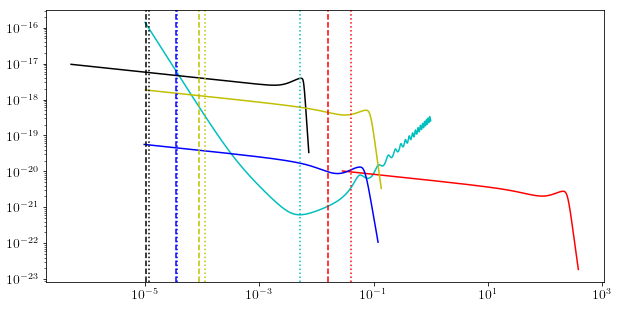

In [149]:
colors = ['c','k','r','b','y']
plt.figure(figsize=(10,5))
plt.loglog(ESA_LISA.fT,ESA_LISA.h_n_f,color=colors[0])
plt.loglog(source_1.f,SnN.Get_CharStrain(source_1),color=colors[1])
plt.loglog(source_2.f,SnN.Get_CharStrain(source_2),color=colors[2])
plt.loglog(source_3.f,SnN.Get_CharStrain(source_3),color=colors[3])
plt.loglog(source_4.f,SnN.Get_CharStrain(source_4),color=colors[4])

plt.axvline(x=f_init.value,color=colors[0],linestyle=':')

for freq_init,freq_end,i in zip(f_init_inst,f_T_obs_inst,range(len(colors))):
    plt.axvline(x=freq_init.value, color=colors[i+1],linestyle='--')
    plt.axvline(x=freq_end.value,color=colors[i+1],linestyle=':')
plt.show()

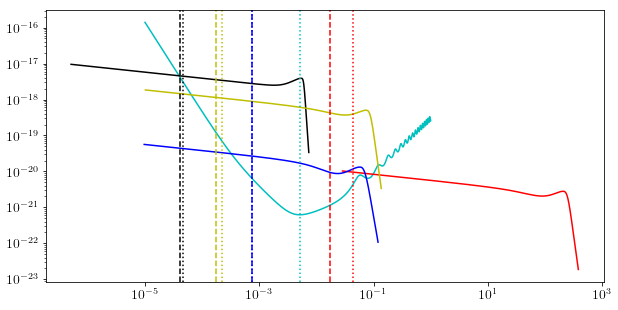

In [150]:
colors = ['c','k','r','b','y']
plt.figure(figsize=(10,5))
plt.loglog(ESA_LISA.fT,ESA_LISA.h_n_f,color=colors[0])
plt.loglog(source_1.f,SnN.Get_CharStrain(source_1),color=colors[1])
plt.loglog(source_2.f,SnN.Get_CharStrain(source_2),color=colors[2])
plt.loglog(source_3.f,SnN.Get_CharStrain(source_3),color=colors[3])
plt.loglog(source_4.f,SnN.Get_CharStrain(source_4),color=colors[4])

plt.axvline(x=f_init.value,color=colors[0],linestyle=':')

for freq_init,freq_end,i in zip(f_init_source,f_T_obs_source,range(len(colors))):
    plt.axvline(x=freq_init.value, color=colors[i+1],linestyle='--')
    plt.axvline(x=freq_end.value,color=colors[i+1],linestyle=':')
plt.show()